- LTV는 고객이 평생동안 기업에게 어느 정도의 금전적 가치를 가져다 주는지를 정량화한 지표로, 고객별 미래의 예상 구매 횟수 * 예상 평균 수익으로 계산됩니다.
- 미래의 예상 구매 횟수는 BG/NBD 모형을 통해 산출되며, 이를 위해 R (Recency), F (Frequency), T (Time) 정보가 필요합니다.
- 미래의 예상 평균 수익은 Gamma-Gamma 모형을 통해 산출되며, 이를 위해 F (Frequency), M (Monetary Value) 정보가 필요합니다.

# 데이터 파악

- 데이터 컬럼
    - InvoiceNo: 송장 번호
    - StockCode: 제품 번호
    - Description: 제품명
    - Quantity: 주문 수량
    - InvoiceDate: 주문 일자 및 시각 (datetime 형태)
    - UnitPrice: 단가 (화폐 단위: 파운드 £)
    - CustomerID: 고객 번호
    - Country: 고객 거주 국가

In [ ]:
import pandas as pd
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials

warnings.filterwarnings('ignore')

df = pd.read_excel("Online Retail.xlsx", engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 데이터 전처리
- 고객마다 일자별로 얼마치 구매했는지 알기 위해 전처리

In [ ]:
# InvoiceDate (주문 일자): Datetime -> date형
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# CustomerID: NULL인 것 제외
df = df[pd.notnull(df['CustomerID'])]

# Quantity (주문 수량): 1 이상인 것
df = df[(df['Quantity'] > 0)]

# Sales (구매 금액) 변수 생성
df['Sales'] = df['Quantity'] * df['UnitPrice']

# 고객 번호, 주문 일자, 구매 금액만 남기고 지우기
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]

df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


# lifetimes 패키지로 RFMT 계산

- BG/NBD 모형과 Gamma-Gamma 모형의 INPUT이 되는 R, F, M, T 만들기

- frequency       ( F ) : 고객별 구매 일수
- recency         ( R ) : 고객별 첫 구매 ~ 마지막 구매까지의 시간
- T               ( T ) : 고객별 첫 구매 ~ 집계일까지의 시간
- moneytary_value ( M ) : 고객별 평균 구매 금액

- lifetimes 함수 정리
    - summary_data_from_transaction_data
        - 구매기록 데이터에서 고객별 RFMT 계산
    - calibration_and_holdout_data
        - 훈련 / 테스트를 나눠 고객별 RFMT 계산
    - fmin
        - L2 penalty 최적화
    - BetaGeoFitter
        - 예상 구매 일수를 구하기 위한 BG/NBD 모형 적함
    - conditional_expected_number_of_purchases_up_to_time
        - t 시점까지의 예상 구매 일수 계산
    - GammaGammaFitter
        - 예상 평균 구매 금액을 구하기 위한 Gamma-Gamma 모형 적합
    - conditional_expected_average_profit
        - 예상 평균 구매 금액 계산
    - customer_lifetime_value
        - 고객별 LTV 계산
    

In [ ]:
current_date = df['InvoiceDate'].max()

metrics_df = summary_data_from_transaction_data(df
                                          , customer_id_col = 'CustomerID'
                                          , datetime_col = 'InvoiceDate'
                                          , monetary_value_col='Sales'
                                          , observation_period_end=current_date)
metrics_df.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


- 해석 예시

In [ ]:
metrics_df[metrics_df.index==12347]

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,599.701667


- 총 6번 구매했고 (frequency),
- 마지막 구매일 - 첫 구매일은 365일 (recency),
- 집계일 - 첫 구매일은 367일 (T)이며,
- 평균 구매 금액은 600 정도 (monetary_value)임을 의미합니다.

- 직접 계산할 경우

In [ ]:
example = df[df['CustomerID']==12347]

# frequency = 6, 구매 일수
print(len(example['InvoiceDate'].unique())-1)

# recency = 365: 최대 주문일 - 최소 주문일
print(max(example['InvoiceDate']) - min(example['InvoiceDate']))

# T = 367: 집계일 - 최소 주문일
print(current_date - min(example['InvoiceDate']))

# monetary_value = 599.701667, 평균 구매 금액
ex_daily_sales = example.groupby("InvoiceDate")["Sales"].sum()
print(np.mean(ex_daily_sales[1:]))

print('''
=>
frequency (F)는 InvoiceDate의 유니크 개수 - 1 (첫 구매일은 포함하지 않습니다)
recency (R)은 CustomerID = 12347 고객의 InvoiceDate 최대값 - 최소값
time (T)은 집계일 current_date에서 InvoiceDate 최소값
monetary_value (M)는 일별 구매 금액의 평균 (마찬가지로 첫 구매일은 포함하지 않습니다) 로 계산됩니다.

F와 M을 계산할 때 첫 구매일을 제외하는 이유는 “반복되는 구매 행위”에 대한 통계를 계산하고 있기 때문에 시작점을 포함하지 않습니다.
''')

6
365 days, 0:00:00
367 days, 0:00:00
599.7016666666667

=>
frequency (F)는 InvoiceDate의 유니크 개수 - 1 (첫 구매일은 포함하지 않습니다)
recency (R)은 CustomerID = 12347 고객의 InvoiceDate 최대값 - 최소값
time (T)은 집계일 current_date에서 InvoiceDate 최소값
monetary_value (M)는 일별 구매 금액의 평균 (마찬가지로 첫 구매일은 포함하지 않습니다) 로 계산됩니다.

F와 M을 계산할 때 첫 구매일을 제외하는 이유는 “반복되는 구매 행위”에 대한 통계를 계산하고 있기 때문에 시작점을 포함하지 않습니다.



# 최적의 L2 penalty 파라미터 찾기

- 고객 각각의 RFMT를 계산했으니 이 데이터를 BG/NBD 모형과 Gamma-Gamma 모형의 INPUT으로 넣어주면 됩니다.

- 그런데 모형을 적합시킬 때 다음과 같이 penalizer_coef 인자에 L2 penalty를 넣어준다면 모형을 좀 더 강건하게 만들어줄 수 있습니다.

In [ ]:
# model = BetaGeoFitter(penalizer_coef=l2_reg)
# model = GammaGammaFitter(penalizer_coef=l2_reg)

## TRAIN / TEST 데이터 나누기
    - 마지막 90일(3달)을 테스트 데이터로 구축

In [ ]:
holdout_days = 90
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(df
                                          ,customer_id_col = 'CustomerID'
                                          ,datetime_col = 'InvoiceDate'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,monetary_value_col='Sales')

metrics_cal_df.head()


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346.0,0.0,0.0,235.0,0.0000,0.0,0.000000,90.0
12347.0,4.0,238.0,277.0,519.7675,2.0,26.192069,90.0
12348.0,2.0,110.0,268.0,297.2200,1.0,103.333333,90.0
12350.0,0.0,0.0,220.0,0.0000,0.0,0.000000,90.0
12352.0,3.0,34.0,206.0,421.7700,3.0,20.090000,90.0


- calibration 기간 동안의 RFMT를 계산한 값은 _cal이 붙고, TEST 기간 동안의 F와 M을 계산한 값은 _holdout이 붙습니다
- duration_holdout은 holdout data이 며칠인지 나타내는 컬럼

## 최종 데이터 만들기

- BG/NBD 모형과 Gamma-Gamma 모형의 INPUT을 정리
- 고객별 RFMT가 들어간 데이터에서 frequency가 1 이상인 데이터만 가져오기
    - 이 고객들은 전체 기간 동안 구매 일수가 1일인 유저입니다. (frequency는 총 구매일수 - 1) 이들은 “반복적인” 구매를 한 고객들이 아니라서 BG/NBD 모형 가정에서 벗어난 고객들이기 때문에 제외

- whole_filtered_df:
    - L2 페널티를 최적화한 후에 제일 마지막에 LTV를 계산할 때 쓸 데이터이고 (calibration / holdout을 나누지 않은 데이터)
- filtered_df:
    - L2 페널티를 최적화하기 위해 calibration / holdout을 나눈 데이터입니다.

In [ ]:
## frequency가 0인 것은 제외하기
whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df       = metrics_cal_df[metrics_cal_df.frequency_cal > 0]

- score_model:
    - 실제값과 예측값의 차이에 대한 지표 (MSE / RMSE/ MAE)를 계산하는 함수
- evaluate_bgnbd_model:
    - calibration data와 l2_reg를 넣어 BG/NBD 모형을 적합시키고, holdout data의 구매 일수 (frequency)에 대한 실제값과 예측값에 대한 MSE를 계산하는 함수
- evaluate_gg_model:
    - calibration data와 l2_reg를 넣어 Gamma-Gamma 모형을 적합시키고, holdout data의 평균 구매 금액 (monetary value)에 대한 실제값과 예측값에 대한 MSE를 계산하는 함수

In [ ]:
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()
    mse = np.sum(np.square(actuals-predicted))/actuals.shape[0]

    # MSE / RMSE
    if metric=='mse': # or metric=='rmse':
        val = mse
    elif metric=='rmse':
        val = np.sqrt(mse)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가
def evaluate_gg_model(param):

    data   = inputs
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

- BG/NBD 모형의 최적 L2 Penalty

In [ ]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model, # 목적함수
  space = search_space,      # 파라미터 공간
  algo = algo,               # 최적화 알고리즘: Tree of Parzen Estimators (TPE)
  max_evals=100,             # 반복수
  trials=trials
  )

l2_bgnbd = space_eval(search_space,argmin)
print(l2_bgnbd)

100%|██████████████████████████████████████████████| 100/100 [00:11<00:00,  9.02trial/s, best loss: 2.9944108626186776]
0.9994862675184638


- Gamma-Gamma 모형의 최적 L2 Penalty

In [ ]:
trials = Trials()

# GammaGamma
argmin = fmin(
  fn = evaluate_gg_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_gg = space_eval(search_space,argmin)
print(l2_gg)

100%|███████████████████████████████████████████████| 100/100 [00:04<00:00, 24.48trial/s, best loss: 350.5635453332647]
0.009810764321253607


## BG/NBD 모형 및 Gamma-Gamma 모형 적합하기

### BG/NBD 모형 적합
- BG/NBD 모형은 고객별 미래의 구매 횟수를 예측하기 위한 모형

In [ ]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd) #l2_bgnbd = hyperopt로 나온 결과
# calibration 데이터의 R,F,T로 모형 적합
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])

# holdout 데이터로 모델 평가: F의 실제값과 예측값의 MSE
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal']
                                    , filtered_df['recency_cal']
                                    , filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
print('MSE: {0}'.format(mse))
print(
'''
=> 평균 제곱오차가 +- 3일 정도라고 할 수 있다.
'''
)

MSE: 2.9944108626186776

=> 평균 제곱오차가 +- 3일 정도라고 할 수 있다.



- BG/NBD 모형 해석

- BG/NBD 모형 가정:
    - 고객이 남아있는 동안, 일정한 기간 T 동안의 구매 횟수는 Pois(λT)를 따릅니다. 위에서 말씀 드렸듯이 1일 간 Pois (1/12)를 따른다면 T= 1년일 경우 Pois (30)을 따르게 되겠죠! (포아송의 모수인 λT는 예상 구매 횟수 를 의미합니다)
    - 고객마다 일정한 기간 동안 구매하는 횟수는 다릅니다. 이는 λ ~ Gamma (r,α)을 따릅니다.
    - j번째 구매가 마지막이고 더 이상 구매를 하지 않을 확률 (이탈률)은 p입니다. 이탈할 때까지의 구매 횟수는 Geo (p)를 따릅니다.
    - 고객마다 더 이상 구매를 하지 않을 확률 (이탈률)은 다릅니다. 이탈률 p는 p ~ Beta (a,b)를 따릅니다.
    - 고객별 일정 기간 동안의 구매 횟수와 구매를 하지 않을 확률은 서로 영향을 주지 않습니다.
- 여기서 2번에 해당하는 Gamma(r, α)와 4번에 해당하는 Beta(a, b)가 lifetimes_model에서 추정되는 파라미터.    
- 이를 활용해 고객마다 일정한 기간 동안 구매하는 횟수의 분포와 고객별 더 이상 구매하지 않을 확률의 분포를 그릴 수 있다.

In [ ]:
lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.452821,0.009715,0.433780,0.471863
alpha,23.817382,1.007104,21.843457,25.791307
a,0.000557,0.000737,-0.000887,0.002001
b,0.012793,0.015664,-0.017909,0.043494


- 1) 고객마다 일정한 기간 동안 구매하는 횟수 λ는 Gamma(r,alpha)을 따른다.


여기서 T 기간동안의 평균 구매 횟수가 λT 이므로 λ에 대한 분포는 1일 단위입니다.
위 그림에서 0.2쯤부터 확률이 0으로 수렴하고 있는데 대부분 고객들이 1일의 평균 구매 횟수는 
최대 0.2 정도임을 의미합니다. 즉, 최대 5일에 한 번 꼴로 구매한다라 볼 수도 있다.



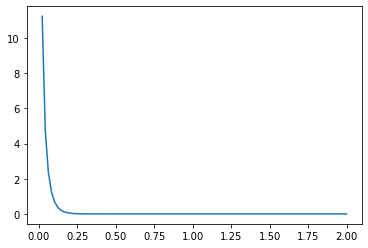

In [ ]:
from scipy.stats import gamma
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100)
y = gamma.pdf(x, a=coefs['r'], scale=1/coefs['alpha']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수!

plt.plot(x, y)

print('''
여기서 T 기간동안의 평균 구매 횟수가 λT 이므로 λ에 대한 분포는 1일 단위입니다.
위 그림에서 0.2쯤부터 확률이 0으로 수렴하고 있는데 대부분 고객들이 1일의 평균 구매 횟수는
최대 0.2 정도임을 의미합니다. 즉, 최대 5일에 한 번 꼴로 구매한다라 볼 수도 있다.
''')

- 2) 고객이 더 이상 구매를 하지 않을 확률은 Beta(a,b)를 따른다.


분포가 0과 1 근처로 양극단에 위치한 것을 볼 수 있습니다. 
즉 더 이상 구매를 하지 않을 확률이 0인 active한 유저도 많고, 
확률이 1 근처인 inactive한 유저도 많음을 알 수 있습니다.



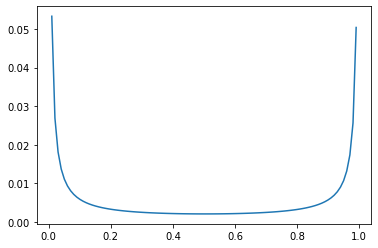

In [ ]:
from scipy.stats import gamma,beta
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 1, 100)
y = beta.pdf(x, a=coefs['a'], b=coefs['b']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수!

plt.plot(x, y)

print('''
분포가 0과 1 근처로 양극단에 위치한 것을 볼 수 있습니다.
즉 더 이상 구매를 하지 않을 확률이 0인 active한 유저도 많고,
확률이 1 근처인 inactive한 유저도 많음을 알 수 있습니다.
''')

### Gamma-Gamma 모형 적합
- 평균 구매 금액을 모델링 하기 위한 Gamma-Gamma모형 적합

In [ ]:
spend_model = GammaGammaFitter(penalizer_coef=l2_gg)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 350.5635453332647


- 히스토그램을 통해 실제와 예측된 평균 구매금액 차이 확인

어느 정도 분포가 비슷함을 볼 수 있다.


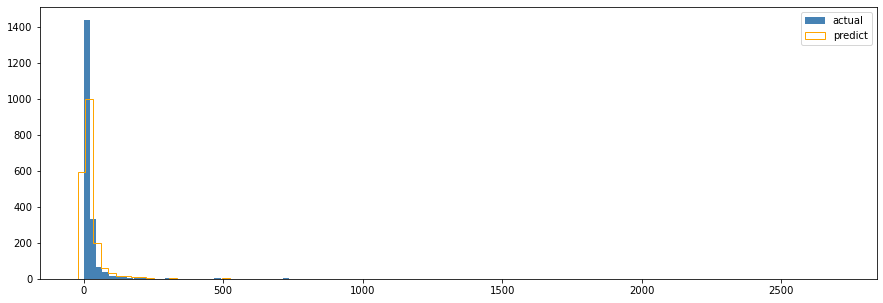

In [ ]:
bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

print('어느 정도 분포가 비슷함을 볼 수 있다.')

- 패널티를 주지 않고 결과 비교 시각화

penalized_coef=0으로 두었을 땐 파란 막대와 주황 막대의 분포가 전혀 다름을 확인할 수 있다.


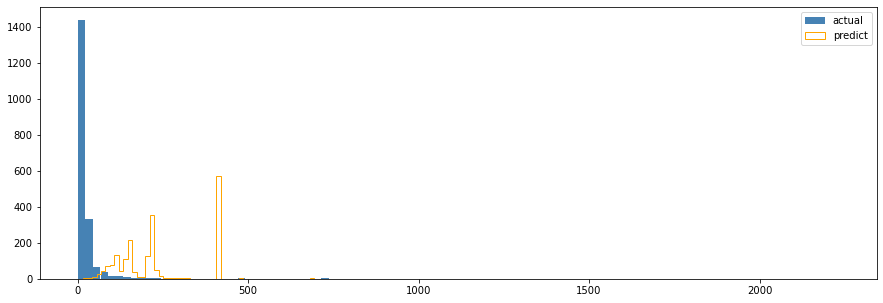

In [ ]:
# penalizer_coef 없이 했을 때의 결과
spend_model = GammaGammaFitter(penalizer_coef=0)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# 평가
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

print('penalized_coef=0으로 두었을 땐 파란 막대와 주황 막대의 분포가 전혀 다름을 확인할 수 있다.')

# LTV 구하기

-  BG/NBD 모형과 Gamma-Gamma 모형을 합쳐 LTV 구하는 부분
    - lifetimes_model ( BetaGeoFitter )
    - spend_model ( GammaGammaFitter )
    - time : 향후 몇 개월동안의 LTV를 볼 것인지 ( time=12개월 )
    - discount_rate : 어느정도의 할인율을 적용할 것인지

In [ ]:
final_df = whole_filtered_df.copy()
final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                     final_df['frequency'],
                                                     final_df['recency'],
                                                     final_df['T'],
                                                     final_df['monetary_value'],
                                                     time=12,
                                                     discount_rate=0.01 # monthly discount rate ~12.7% 연간
                                                     )

- 365일 동안의 예상 구매 횟수 구할 시

In [ ]:
t=365 #365일
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

In [ ]:
final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(final_df['frequency']
                                                                    ,final_df['monetary_value'])

In [ ]:
final_df.sort_values(by="ltv").tail(5)

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
CustomerID,,,,,,,
17450.0,26.0,359.0,367.0,7404.690385,163233.284366,24.699139,7144.098119
14096.0,16.0,97.0,101.0,4071.434375,171476.631670,48.085829,3854.836146
16446.0,1.0,205.0,205.0,168469.600000,172828.907358,2.219387,84178.331306
18102.0,25.0,367.0,367.0,9349.477200,197946.884059,23.765789,9003.615503
14646.0,44.0,353.0,354.0,6366.705909,247585.437580,42.934914,6233.543383


- 14646고객의 LTV가 제일 높은 결과 확인 가능
- 평균 구매액은 6366정도
- 353일 동안 44번 구매 ( 평균 8일에 한번 구매 )
- T(집계일) - recency(마지막 구매 일자) = 1로 어제도 구매한 결과 확인 가능